# Train CLIP model on long flicker dataset (need to have done preprocessing)

In [73]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [74]:
%cd gdrive

[Errno 2] No such file or directory: 'gdrive'
/content/gdrive


In [75]:
import sys
colab_file_dir='My Drive/Colab Notebooks' # where clip_helpers.py is for me
sys.path.append(colab_file_dir)

In [77]:
import os
import pandas as pd
import re
import numpy as np
import random
import zipfile
import requests
import io
import math
from pathlib import Path
import datetime
import csv

from dataclasses import dataclass

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import register_keras_serializable
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.metrics import Mean
from tensorflow.keras.layers import Dropout, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder

# Pour utiliser au mieux le GPU
AUTOTUNE = tf.data.AUTOTUNE


In [236]:

# Classes à utiliser pour la partie classification de texte. Laquelle ?
  ## --> pratique si on récupère le premier token 'CLS' style
@register_keras_serializable()
class SelectFirstToken (layers.Layer):
  # Retourne le premier mot
    def call(self, inputs):
        return inputs[:, 0] # (batch, embed_dim)

@register_keras_serializable()
class SelectMean(layers.Layer):
  # Retourne la moyenne des mots - bien si pas trop de PAD - chaînes même taille
    def call(self, inputs):
        # inputs: (batch, seq_len, embed_dim)
        return tf.reduce_mean(inputs, axis=1)  # (batch, embed_dim)


@register_keras_serializable()
class MaskedMean(layers.Layer):
  # Retourne la moyenne des mots sans être trop influencé par PAD
    def call(self, inputs):
        seq_out, token_ids = inputs   # (B,L,D), (B,L)
        mask = tf.cast(tf.not_equal(token_ids, 0), seq_out.dtype)  # PAD=0
        mask = tf.expand_dims(mask, -1)        # (B,L,1)
        summed = tf.reduce_sum(seq_out * mask, axis=1)             # (B,D)
        counts = tf.reduce_sum(mask, axis=1)                        # (B,1)
        return summed / tf.maximum(counts, 1.0)


# Classe utile pour la partie Clip mais il fallait bien regarder pour la trouver
@register_keras_serializable()
class L2Normalize(layers.Layer):
    def __init__(self, axis=-1, **kwargs):
        super().__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=self.axis)

    def get_config(self):
        config = super().get_config()
        config.update({"axis": self.axis})
        return config

# PARTIE SMALL_BERT = COPIE DU NOTEBOOK
# ============================
# PositionalEmbedding Layer
# ============================
@tf.keras.utils.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(input_dim=vocab_size,
                                                 output_dim=embed_dim)
        self.position_embeddings = layers.Embedding(input_dim=sequence_length,
                                                    output_dim=embed_dim)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(0, length)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config

# ============================
# TransformerBlock
# ============================
@tf.keras.utils.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.supports_masking = True
        self.att = layers.MultiHeadAttention(num_heads=num_heads,
                                             key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training=False, mask=None):
        seq_len = tf.shape(inputs)[1]
        attn_mask = None
        if mask is not None:
            attn_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.float32)
            attn_mask = tf.tile(attn_mask, [1, seq_len, 1])

        attn_output = self.att(inputs, inputs, inputs, attention_mask=attn_mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

        def get_config(self):
            config = super().get_config()
            config.update({
                "embed_dim": self.att.key_dim,
                "num_heads": self.att.num_heads,
                "ff_dim": self.ffn.layers[0].units,
                "dropout_rate": self.dropout1.rate,
            })
            return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# ============================
# SmallBERT encoder
# ============================
@register_keras_serializable()
class SmallBERT(tf.keras.Model):
    def __init__(self, sequence_length, vocab_size, embed_dim, num_heads,
                 ff_dim, num_layers, **kwargs):
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbedding(sequence_length, vocab_size,
                                                 embed_dim)

        self.transformer_blocks = [
              TransformerBlock(embed_dim,
                             num_heads, ff_dim) for _ in range(num_layers)
        ]
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout = tf.keras.layers.Dropout(0.2)

    def call(self, inputs, training=False):
        x = self.pos_embedding(inputs)
        for block in self.transformer_blocks:
            x = block(x, training=training)
        x = self.layernorm(x)
        return self.dropout(x, training=training)

    def get_config(self):
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "num_layers": self.num_layers,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


# Perte contrastive CLIP
# Le but de cette fonction est d’aligner les embeddings d’images et de textes
# correspondants dans un espace latent partgé. Elle est inspirée du papier
# CLIP, où l'on entraîne le modèle à prédire quelle image correspond à quel
# texte et réciproquement.

@register_keras_serializable(package="clip")
class ClipLossLayer(layers.Layer):
    def __init__(self, temperature=0.14, **kwargs):
        # inital temp was 0.07
        super().__init__(**kwargs)
        self.temperature = temperature
        self.clip_loss_metric = tf.keras.metrics.Mean(name="clip_loss")

    def call(self, inputs):
        # l'inputs est forcément (img, txt) ou [img, txt]
        img, txt = inputs  # (B, D) attention il faut avoir L2-normalisés !!

        # Matrice des similarités (cosinus parce qu'on a L2 zt ça simplifie)
        logits = tf.matmul(img, txt, transpose_b=True) / self.temperature

        # Les Labels implicites : c'est la diagonale
        labels = tf.range(tf.shape(logits)[0])

        li = tf.keras.losses.sparse_categorical_crossentropy(labels,
                                                             logits,
                                                             from_logits=True)
        lt = tf.keras.losses.sparse_categorical_crossentropy(labels,
                                                          tf.transpose(logits),
                                                          from_logits=True)
        loss = tf.reduce_mean(li + lt) / 2.0

        # Ca c'est super important car on ajoute la loss au graphe
        # du modèle et ça nous simplifie la vie
        # après on met à jour la métrique interne si on veut la suivre
        self.add_loss(loss)
        self.clip_loss_metric.update_state(loss)

        # On retourne un TUPLE de tenseurs(surtout pas une liste)
        # dc facileà récupérer
        return (img, txt)

    def get_config(self):
        return {**super().get_config(), "temperature": self.temperature}

In [237]:
def plot_history_simple(history):
    """
    Trace côte à côte les courbes Loss et Accuracy (train/val si dispo)
    à partir d'un objet Keras History.
    """
    hist = history.history

    # compatibilité anciennes versions ("acc"/"val_acc")
    acc_key = "accuracy" if "accuracy" in hist else "acc"
    val_acc_key = "val_accuracy" if "val_accuracy" in hist else "val_acc"

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- Loss ---
    if "loss" in hist:
        axes[0].plot(hist["loss"], label="train")
    if "val_loss" in hist:
        axes[0].plot(hist["val_loss"], label="val")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # --- Accuracy ---
    if acc_key in hist:
        axes[1].plot(hist[acc_key], label="train")
        if val_acc_key in hist:
            axes[1].plot(hist[val_acc_key], label="val")
        axes[1].set_title("Accuracy")
        axes[1].set_xlabel("Epoch")
        axes[1].set_ylabel("Accuracy")
        axes[1].legend()
    else:
        axes[1].set_visible(False)  # si pas d'accuracy, on masque le 2e plot

    plt.tight_layout()
    plt.show()

def save_history_csv(history, filename):
    """save history as csv file"""
    history_dict = history.history
    keys = history_dict.keys()  # headers
    rows = zip(*history_dict.values())  # values

    with open(filename, "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(keys)
        writer.writerows(rows)

# Load parameters

In [273]:
def get_default_params(
        dataset_dir="./flickr_long_subset",
        model_dir="./models_forclip") -> dict:

    # returns a dictionary with all the parameters
    # parameters can be modified
    train_dir = os.path.join(dataset_dir, "train_data")
    val_dir = os.path.join(dataset_dir, "val_data")
    test_dir = os.path.join(dataset_dir, "test_data")

    train_image_dir = os.path.join(train_dir, "images")
    train_captions_dir = os.path.join(train_dir, "captions")
    train_captions_csv_path = os.path.join(train_dir, "captions.csv")

    val_image_dir = os.path.join(val_dir, "images")
    val_captions_dir = os.path.join(val_dir, "captions")
    val_captions_csv_path = os.path.join(val_dir, "captions.csv")

    test_image_dir = os.path.join(test_dir, "images")
    test_captions_dir = os.path.join(test_dir, "captions")
    test_captions_csv_path = os.path.join(test_dir, "captions.csv")

    # token form train dataset
    vocab_path = os.path.join(dataset_dir, "vocab.txt")

    image_size = (224, 224)

    param_dict = {
        # directories for data and model weights
        "model_dir": model_dir,
        "dataset_dir": dataset_dir,

        "train_dir": train_dir,
        "train_image_dir": train_image_dir,
        "train_captions_dir": train_captions_dir,
        "train_captions_csv_path": train_captions_csv_path,

        "val_dir": val_dir,
        "val_image_dir": val_image_dir,
        "val_captions_dir": val_captions_dir,
        "val_captions_csv_path": val_captions_csv_path,

        "test_dir": test_dir,
        "test_image_dir": test_image_dir,
        "test_captions_dir": test_captions_dir,
        "test_captions_csv_path": test_captions_csv_path,

        "vocab_path": vocab_path,

        # model training parameters
        # Attention respecter bien l'ordre alphabétique des classes pour
        # le générateur
        "class_names": ['ball', 'bike', 'dog', 'water'],
        # class encoding dict
        "class_dict": {
            "ball": 0,
            "bike": 1,
            "dog": 2,
            "water": 3
        },
        # Pour les images
        "image_size": image_size,
        "image_shape": image_size + (3,),


        # Pour les textes
        "sequence_length": 32,
        "vocab_size": 10000,
        "num_heads": 4,
        "ff_dim": 128,
        "num_layers": 2,
        "nb_image_filters": 32,
        "pad_sequence": True,

        # Pour les images et les textes dans le modèle CLIP
        "embed_dim": 128,
        "learning_rate": 2e-4,
        "data_augmentation": True,

        # pour le training:
        "patience": 10,
        "batch_size": 64,
        "nb_epochs": 30,
    }

    return param_dict


In [274]:
# Set your directories here
dataset_dir = "My Drive/ML2_projet/flickr_long_subset"  # diretory with train/val/test folders
model_dir = "My Drive/ML2_projet/models_forclip"

param_dict = get_default_params(
    dataset_dir=dataset_dir,
    model_dir=model_dir
)



# Build, train and save model

In [275]:
# DATA LOADER
def make_clip_dataset(
        dataset_dir,
        captions_csv_path,
        tokenizer_layer,
        batch_size=16,
        shuffle=True,
        drop_remainder=True,
        cache=True,
        seed=42):

    """
    Construit un tf.data.Dataset avec en sortie (images, token_ids) pour CLIP.
    """
    # On récupère le fichier captions.csv qui a tout
    df = pd.read_csv(captions_csv_path)
    image_paths = df["image_path"].astype(str).tolist()
    captions = df["caption"].fillna("").astype(str).tolist()

    # Récupération du répertoire des images
    root = Path(dataset_dir)
    full_paths = [str(root / p) for p in image_paths]

    # Création du dataset d'image
    ds = tf.data.Dataset.from_tensor_slices((full_paths, captions))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(full_paths), seed=seed,
                        reshuffle_each_iteration=True)

    # Chargement d'une ensemble d'images normalisées et de tokens (le texte)
    IMAGE_H, IMAGE_W = 224, 224  # même que image_size

    def load_sample(img_path, caption):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, [IMAGE_H, IMAGE_W])
        img = tf.image.convert_image_dtype(img, tf.float32)  # [0,1]
        tokens = tf.cast(tokenizer_layer(caption), tf.int32)  # (L,)

        # x = dict des 2 entrées, pour forcer à ne pas avoir de  y
        return {"image_input": img, "text_input": tokens}

    # Pour utiliser le cache et pouvoir faire les traitements en //
    ds = ds.map(load_sample, num_parallel_calls=AUTOTUNE)
    if cache:
        ds = ds.cache()
    # si drop_remainder=True on vire le dernier batch
    # s'il n'est pas de la bonne taille
    ds = ds.batch(batch_size, drop_remainder=drop_remainder).prefetch(AUTOTUNE)
    return ds

In [296]:
# MODEL BUILDER
def build_clip_model(
        sequence_length,
        vocab_size,
        embed_dim,
        num_attention_heads,
        ff_dim,
        num_layers,
        nb_image_filters=32,
        pad_sequence: bool = True,
        compile=True,
        learning_rate=1e-4,
        data_augmentation=True):

    # Part 1: Text encoding
    # Text inputs (need layer name to match tf.dataset keys)
    # Text inputs are already tokenized
    text_inputs = layers.Input(shape=(sequence_length,), dtype=tf.int32, name="text_input")

    # smallBertEncoding
    # attention mask will be determined by the bert model
    base_model = SmallBERT(
        sequence_length=sequence_length,
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        num_heads=num_attention_heads,
        ff_dim=ff_dim,
        num_layers=num_layers
    )(text_inputs)

    # Final vector representation
    # how to compress information to a single vector
    # text_vector = MaskedMean()((base_model, text_inputs))
    text_vector = MaskedMean()((base_model, text_inputs))

    # add some dropout to see if it helps with overtraining
    text_vector_droupout = layers.Dropout(0.2)(text_vector)

    # normalize
    norm_text_vector = L2Normalize(name="text_latent_vector")(text_vector_droupout)

    print("start building image model")
    # Part 2: Image encoding
    # Image inputs (need layer name to match tf.dataset keys)
    image_inputs = tf.keras.Input(shape=(224, 224, 3), name='image_input')

    # Image processing
    rescaling_layer = Rescaling(1./255)(image_inputs)

    # data augmentation
    # randlomly change image data a little
    if (data_augmentation):
        # flip image randolmy
        # test horizontal and versical maybe ?
        flipLayer = layers.RandomFlip(
            mode="horizontal")(rescaling_layer)

        # rotate image randomly
        rotationLayer = layers.RandomRotation(
            factor=0.2,  # can rotate up to 20% of a full rotation left and right
            )(flipLayer)

        # Zoom randomly
        zoomLayer = layers.RandomZoom(
            height_factor=(0.2, 0.2),  # can zoom in and out to 20% and keep image ratio
            )(rotationLayer)

        # still training too fast, need to add additional layers of
        # Randomly change brightness and contrast
        contrastLayer = layers.RandomContrast(0.4)(zoomLayer)

        # # Still overfitting after 3-4 epochs
        brightnessLayer = layers.RandomBrightness(0.1)(contrastLayer)

        # Slightly better but still overfitting
        translationLayer = layers.RandomTranslation(0.1,0.1)(brightnessLayer)

        x = translationLayer
    else:
        x = rescaling_layer
    # CNN encoding
    convolution_layer1 = Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    max_pooling_layer1 = MaxPooling2D(pool_size=(2, 2))(convolution_layer1)

    convolution_layer2 = Conv2D(filters=64, kernel_size=3, padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001))(max_pooling_layer1)
    max_pooling_layer2 = MaxPooling2D(pool_size=(2, 2))(convolution_layer2)

    convolution_layer3 = Conv2D(filters=128, kernel_size=3, padding="same", activation="relu", kernel_regularizer=regularizers.l2(0.001))(max_pooling_layer2)
    max_pooling_layer3 = MaxPooling2D(pool_size=(2, 2))(convolution_layer3)

    flatten_layer = Flatten()(max_pooling_layer3)
    # set image latent space size equal to text latent space size
    image_vector = Dense(
        embed_dim,
        activation="relu")(flatten_layer)

    # Normalize
    norm_image_vector = L2Normalize(name="image_latent_vector")(image_vector)

    # CLIP part
    print("start building clip part")
    # Compute clip distance
    clip_layer = ClipLossLayer(name="clip_loss_layer")([norm_image_vector, norm_text_vector])

    # Final part: build model
    print("build full model")
    # final model
    final_model = keras.Model(inputs=[image_inputs, text_inputs], outputs=clip_layer, name="clip_training")
    final_model.summary()

    if compile:
        print("compile")
        # No loss in compile, it's in the model --> I AM BLIND THIS WAS THE ANSWER ALL ALONG..
        final_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate)
        )
    return final_model

In [297]:
# TRAIN AND SAVE
def train_model(
        model_config: dict,  # dict with all params (loaded from load_default_params),
        model_name: str,  # basename of the model
        ):

    # Train and save the model weights to given location

    full_model_name = "_".join([
        model_name,
        str(model_config['nb_epochs']),
        "epochs"
    ])

    tokenizer = TextVectorization(
        max_tokens=model_config['vocab_size'],
        standardize='lower_and_strip_punctuation',
        split='whitespace',
        vocabulary=model_config["vocab_path"],
        pad_to_max_tokens=model_config["pad_sequence"],
        output_sequence_length=model_config["sequence_length"],
        output_mode="int"  # save 0 for pad tokens
        )

    train_ds = make_clip_dataset(
        model_config["train_dir"],
        model_config["train_captions_csv_path"],
        tokenizer,
        batch_size=model_config["batch_size"])

    val_ds = make_clip_dataset(
        model_config["val_dir"],
        model_config["val_captions_csv_path"],
        tokenizer,
        batch_size=model_config["batch_size"])

    model = build_clip_model(
        sequence_length=model_config["sequence_length"],
        vocab_size=model_config["vocab_size"],
        embed_dim=model_config["embed_dim"],
        num_attention_heads=model_config["num_heads"],
        ff_dim=model_config["ff_dim"],
        num_layers=model_config["num_layers"],
        nb_image_filters=model_config["nb_image_filters"],
        pad_sequence=model_config["pad_sequence"],
        learning_rate=model_config["learning_rate"],
        data_augmentation=model_config["data_augmentation"]
    )

    save_dir = model_config["model_dir"]
    name_model = f"{full_model_name}.weights.h5"
    os.makedirs(save_dir, exist_ok=True)
    model_path = os.path.join(save_dir, name_model)

    callbacks = [
        EarlyStopping(monitor="val_clip_loss", mode="min", patience=model_config["patience"],
                      restore_best_weights=True),
        ModelCheckpoint(model_path, monitor="val_clip_loss", mode="min",
                        save_best_only=True, save_weights_only=True),
        # tensorboard_callback
    ]

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=model_config["nb_epochs"],
        verbose=1,
        callbacks=callbacks)

    # save history
    history_filename = os.path.join(save_dir, f"{full_model_name}_history.csv")
    save_history_csv(history, history_filename)

    return history

In [298]:
# FIrst iteration is longer than the others

history = train_model(
    param_dict,
    "clip_pipeline_model_big_dataset_betterCNN_data_augmentation_bs64_val_loss_patience5_epoch30_latent128_textDrop0.2_3ConvLayer_lessAugmentation_dropoutTransformer_0.2&_lerningrate2-4_temp0.14"
)

start building image model
start building clip part
build full model


Model: "clip_training"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_47        │ (None, 224, 224,  │          0 │ image_input[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_43      │ (None, 224, 224,  │          0 │ rescaling_47[0][… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_43  │ (None, 224, 224,  │          0 │ random_flip_43[0… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_43      │ (None, 224, 224,  │          0 │ random_rotation_… │
│ (RandomZoom)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_contrast_15  │ (None, 224, 224,  │          0 │ random_zoom_43[0… │
│ (RandomContrast)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_brightness_… │ (None, 224, 224,  │          0 │ random_contrast_… │
│ (RandomBrightness)  │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_translation… │ (None, 224, 224,  │          0 │ random_brightnes… │
│ (RandomTranslation) │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_128 (Conv2D) │ (None, 224, 224,  │        896 │ random_translati… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_128   │ (None, 112, 112,  │          0 │ conv2d_128[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_129 (Conv2D) │ (None, 112, 112,  │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_129   │ (None, 56, 56,    │          0 │ conv2d_129[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_130 (Conv2D) │ (None, 56, 56,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_input          │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_130   │ (None, 28, 28,    │          0 │ conv2d_130[0][0]  │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ small_bert_47       │ (None, 32, 128)   │  1,879,040 │ text_input[0][0]  │
│ (SmallBERT)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_47          │ (None, 100352)    │          0 │ max_pooling2d_13

 Total params: 14,817,472 (56.52 MB)

 Trainable params: 14,817,472 (56.52 MB)

 Non-trainable params: 0 (0.00 B)

compile
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'masked_mean_47' (of type MaskedMean) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 753ms/step - clip_loss: 4.2062 - loss: 4.3386 - val_clip_loss: 4.1609 - val_loss: 4.2895
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 267ms/step - clip_loss: 4.1693 - loss: 4.2965 - val_clip_loss: 4.1603 - val_loss: 4.2830
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 508ms/step - clip_loss: 4.1662 - loss: 4.2874 - val_clip_loss: 4.1598 - val_loss: 4.2765
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 240ms/step - clip_loss: 4.1630 - loss: 4.2782 - val_clip_loss: 4.1597 - val_loss: 4.2704
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 271ms/step - clip_loss: 4.1612 - loss: 4.2705 - val_clip_loss: 4.1595 - val_loss: 4.2644
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - clip_loss: 4.1618 - loss: 4.2654 - val_clip_loss: 4.1595 - val_loss: 4.2589
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 270ms/step - clip_loss: 4.1601 - loss: 4.2581 - val_clip_loss: 4.1595 - val_loss: 4.2535
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 233ms/step - clip_loss: 4.1604 - loss: 4.2533 - val_clip_lo

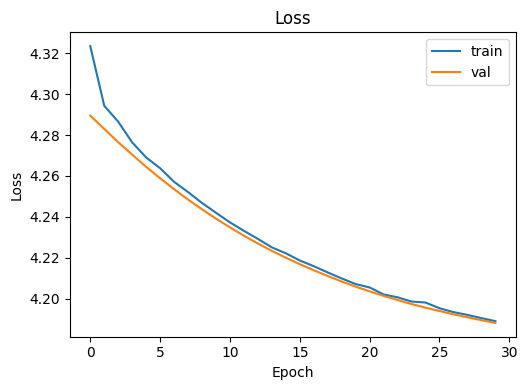

In [299]:
plot_history_simple(history)